### Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import zipfile

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

print(device)

cuda


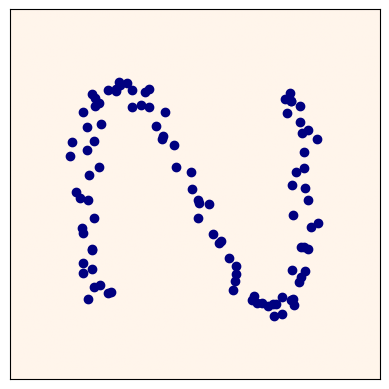

In [ ]:
d = 2   # dimension of the data points

# Second dataset with 100 points
n = 100
t = torch.pi*torch.linspace(-.2,1.2,n)
y = .05*torch.randn((n,d))
y[:,0] += torch.cos(t)
y[:,1] += torch.sin(2*t)
y = .5 + .3*y
y = y.to(device)

# Define masses (empirical measure on the data points)
nu = torch.ones(n, device=device)/n

# generate grid for plotting purpose
nr,nc = 256,256
extent = ((-0.5/nc, 1-0.5/nc, 1-0.5/nr, -0.5/nr))
xs = torch.linspace(0, 1, steps=nr)
ys = torch.linspace(0, 1, steps=nc)
xm, ym = torch.meshgrid(xs, ys, indexing='ij')
xm = xm.T
ym = ym.T
xgrid = torch.cat((xm.reshape(nr*nc,1),ym.reshape(nr*nc,1)),1).to(device)

# Plot data points
fig = plt.figure(dpi=100)
plt.xticks([])
plt.yticks([])
plt.imshow(np.zeros((nr,nc)),cmap = 'Oranges', extent=extent) # background
plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
plt.show()

In [ ]:
class Generator(torch.nn.Module):

    def __init__(self, n_in, n_out, n_hid=10, nlayers=3, device=torch.device("cpu")):
        super(Generator, self).__init__()

        self.n_in = n_in
        self.n_out = n_out
        self.n_hid = n_hid
        self.nlayers = nlayers
        self.hidden = nn.ModuleList()

        for n in range(nlayers):
            n_in_t = n_in if n==0 else n_hid
            self.hidden.append(nn.Sequential(
            nn.Linear(n_in_t, n_hid),
            nn.ELU(1)
        ).to(device))

        self.out = nn.Sequential(
            nn.Linear(n_hid, n_out),
            nn.Sigmoid()
        ).to(device)

        self.apply(self._init_weights)


    def forward(self, x):
        for n in range(self.nlayers):
            x = self.hidden[n](x)
        x = self.out(x)
        return x


    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight, 1.0)
            if module.bias is not None:
                module.bias.data.zero_()


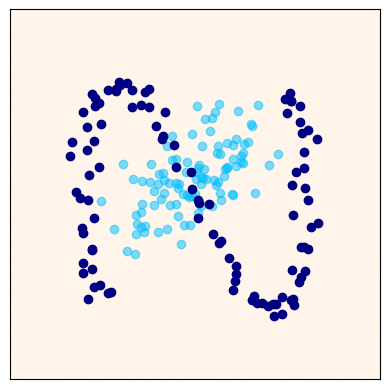

In [ ]:
torch.manual_seed(0)  # initialize random seed for reproducibility

n_in = 10    # dimension of the input noise
b = 100      # batch size
G = Generator(n_in=n_in, n_out=d, n_hid=100, nlayers=3, device=device)

z = torch.randn((b, n_in)).to(device)
x = G(z)

# Plot
xd = x.detach()
fig = plt.figure(dpi=100)
plt.xticks([])
plt.yticks([])
plt.imshow(np.zeros((nr,nc)),cmap = 'Oranges', extent=extent) # background
plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
plt.show()

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, n_in, n_hid=10):
    super(Discriminator, self).__init__()

    self.n_hid = n_hid
    self.n_in = n_in

    self.fc1 = nn.Linear(n_in, n_hid)
    self.fc2 = nn.Linear(n_hid, n_hid)
    self.fc3 = nn.Linear(n_hid, 1)

  def forward(self, x):
    y = nn.LeakyReLU(negative_slope=0.2)(self.fc1(x))
    y = nn.LeakyReLU(negative_slope=0.2)(self.fc2(y))
    y = self.fc3(y)
    return y

In [ ]:
def gradient_penalty(D,x,y):
    b = x.shape[0]
    n = y.shape[0]
    # shrink vectors if they are too large
    if n>b:
        y = y[0:b,:]
        n = b
    else:
        x = x[0:n,:]
        b = n
    # compute interpolated points
    alpha = torch.rand((b,1),device=device)
    interp = (alpha * y + (1 - alpha) * x)
    interp.requires_grad_()

    Di = D(interp).view(-1)

    gradout = torch.ones(Di.size()).to(device)
    gradients = torch.autograd.grad(outputs=Di, inputs=interp, grad_outputs=gradout,
       create_graph=True, retain_graph=True)[0]

    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)
    return ((gradients_norm - 1) ** 2).mean()


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass



✅ Training completed in 94.83 seconds.


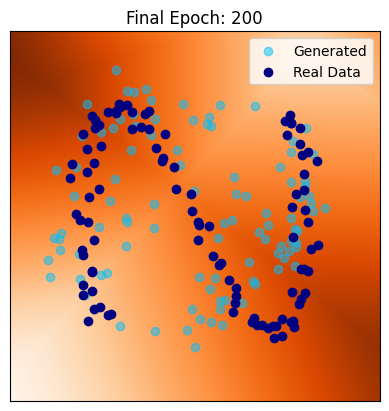

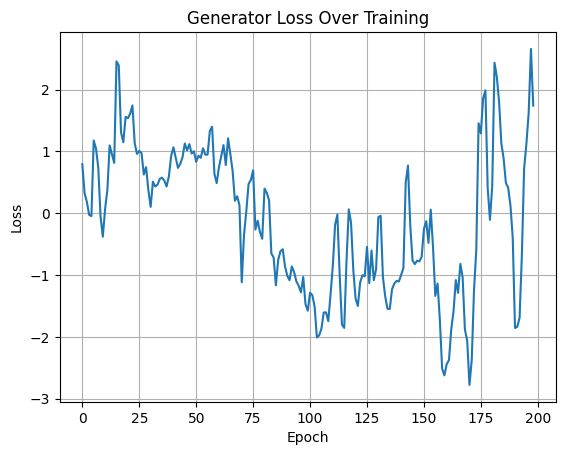

In [ ]:
## parameters for training
n_epochs = 200
niterD = 100
niterG = 10
gpw = .1  # Lower gradient penalty for better generator adaptation

lr = 0.002      # learning rate for generator
lrdisc = 0.005  # learning rate for discriminator
beta_1 = 0.5
beta_2 = 0.999

torch.manual_seed(1)  # reproducibility

# Initialize models
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
optimG = optim.Adam(G.parameters(), lr=lr)

D = Discriminator(n_in=d, n_hid=10).to(device)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))

# Start time
start_time = time.time()

# Training loop
Glosses = []
Dlosses = []

for epoch in range(1, n_epochs):
    for _ in range(niterD):
        optimD.zero_grad()
        z = torch.randn((b, n_in)).to(device)
        real = y
        fake = G(z)
        Dloss = -torch.mean(D(real)) + torch.mean(D(fake)) + gpw * gradient_penalty(D, real, fake)
        Dloss.backward()
        optimD.step()

    for _ in range(niterG):
        optimG.zero_grad()
        z = torch.randn((b, n_in)).to(device)
        fake = G(z)
        Gloss = -torch.mean(D(fake))
        Gloss.backward()
        optimG.step()

    Glosses.append(Gloss.item())
    Dlosses.append(Dloss.item())

# Measure execution time
end_time = time.time()
total_time = end_time - start_time
print(f"\n✅ Training completed in {total_time:.2f} seconds.")

# Final result plot
Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr, nc)
z = torch.randn(b, n_in, device=device)
x = G(z)
xd = x.detach().squeeze(1)

fig = plt.figure(dpi=100)
plt.xticks([])
plt.yticks([])
plt.imshow(Dxgrid, cmap='Oranges', extent=extent)
plt.scatter(xd[:, 0].cpu(), xd[:, 1].cpu(), c='deepskyblue', alpha=.5, label='Generated')
plt.scatter(y[:, 0].cpu(), y[:, 1].cpu(), c='navy', label='Real Data')
plt.title(f'Final Epoch: {n_epochs}')
plt.legend()
plt.show()

# Generator loss curve
plt.figure(dpi=100)
plt.plot(Glosses)
plt.title('Generator Loss Over Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


In [ ]:
## parameters for training
n_epochs = 200
niterD = 100
niterG = 10
gpw = .1  # Lower gradient penalty for better generator adaptation

lr = 0.002      # learning rate for generator
lrdisc = 0.002  # learning rate for discriminator
beta_1 = 0.5
beta_2 = 0.999

torch.manual_seed(1)  # reproducibility

# Initialize models
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
optimG = optim.Adam(G.parameters(), lr=lr)

D = Discriminator(n_in=d, n_hid=10).to(device)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))

# Start time
start_time = time.time()

# Training loop
Glosses = []
Dlosses = []

for epoch in range(1, n_epochs):
    for _ in range(niterD):
        optimD.zero_grad()
        z = torch.randn((b, n_in)).to(device)
        real = y
        fake = G(z)
        Dloss = -torch.mean(D(real)) + torch.mean(D(fake)) + gpw * gradient_penalty(D, real, fake)
        Dloss.backward()
        optimD.step()

    for _ in range(niterG):
        optimG.zero_grad()
        z = torch.randn((b, n_in)).to(device)
        fake = G(z)
        Gloss = -torch.mean(D(fake))
        Gloss.backward()
        optimG.step()

    Glosses.append(Gloss.item())
    Dlosses.append(Dloss.item())

# Measure execution time
end_time = time.time()
total_time = end_time - start_time

# ---- Export all results ---- #

# Save execution time
with open("execution_time.txt", "w") as f:
    f.write(f"{total_time:.4f} seconds")

# Save generator model
torch.save(G.state_dict(), "generator.pth")

# Save final result plot
Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr, nc)
z = torch.randn(b, n_in, device=device)
x = G(z)
xd = x.detach().squeeze(1)

fig = plt.figure(dpi=100)
plt.xticks([])
plt.yticks([])
plt.imshow(Dxgrid, cmap='Oranges', extent=extent)
plt.scatter(xd[:, 0].cpu(), xd[:, 1].cpu(), c='deepskyblue', alpha=.5)
plt.scatter(y[:, 0].cpu(), y[:, 1].cpu(), c='navy')
plt.title(f'Final Epoch: {n_epochs}')
plt.savefig("final_result.png")
plt.close()

# Save generator loss curve
plt.figure(dpi=100)
plt.plot(Glosses)
plt.title('Generator loss over training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig("gloss_curve.png")
plt.close()

# Zip all result files
with zipfile.ZipFile("wgan_training_output.zip", "w") as zipf:
    zipf.write("execution_time.txt")
    zipf.write("generator.pth")
    zipf.write("gloss_curve.png")
    zipf.write("final_result.png")
